#### This is a simple example of applying the trained WaveDecompNet to continuous waveforms. The model is trained partly on IU.POHA data (2021/06/01-2021/07/01). In this example, we will apply the trained model to 1-day continous data of IU.POHA and HV.HAT. Both are not included in the training process. The catalog in the same period is used for validation of the separated waveform.

In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import time as timing

# import the Obspy modules that we will use in this exercise
import obspy
sys.path.append('./..')
from torch_tools import *

import torch
from torch.utils.data import DataLoader

#### Load the one-day continuous seismic data at Hawaii to test the train WaveDecompNet model

In [2]:
# waveform_file = './continuous_data/IU.POHA.20210807-20210808.mseed' # the station we used to train the model
waveform_file = './continuous_data/HV.HAT.20210807-20210808.mseed' # another station to test generalization

tr = obspy.read(waveform_file)
tr.merge(fill_value=0)  # in case that there are segmented traces
tr.decimate(int(tr[0].stats.sampling_rate/10)) # donwsample to 10 Hz
tr.filter('highpass', freq=0.5) # this filtering is actually optional, please feel free to try

3 Trace(s) in Stream:
HV.HAT..HHE | 2021-08-07T00:00:00.005000Z - 2021-08-07T23:59:59.905000Z | 10.0 Hz, 864000 samples
HV.HAT..HHN | 2021-08-07T00:00:00.005000Z - 2021-08-07T23:59:59.905000Z | 10.0 Hz, 864000 samples
HV.HAT..HHZ | 2021-08-07T00:00:00.005000Z - 2021-08-07T23:59:59.905000Z | 10.0 Hz, 864000 samples

#### Reformating the 3-component waveform data to the input dimension for WaveDecompNet

In [3]:
npts0 = tr[0].stats.npts  # number of samples
npts = npts0 // 600 * 600 # slightly adjust the time point for the 600 input size (will be updated soon)

# Reformat the waveform data into array
waveform = np.zeros((npts, 3))
for i in range(3):
    waveform[:, i] = tr[i].data[:npts]

In [4]:
# Reformat the data into the format required by the model (batch, channel, samples)
data_mean = np.mean(waveform, axis=0)
data_std = np.std(waveform, axis=0)
waveform_normalized = (waveform - data_mean) / (data_std + 1e-12)
waveform_normalized = np.reshape(waveform_normalized[:, np.newaxis, :], (-1, 600, 3))
print(waveform_normalized.shape) # batches x features x channels

(1440, 600, 3)


#### Load the trained model and apply it to the continuous data

In [5]:
#  Convert to Dataset object for WaveDecompNet
waveform_data = WaveformDataset(waveform_normalized, waveform_normalized)

In [6]:
# %% Need to specify model_name first
model = torch.load('../Branch_Encoder_Decoder_LSTM/Branch_Encoder_Decoder_LSTM_Model.pth', map_location='cpu') # CPU is enough for prediction

batch_size = 256
test_iter = DataLoader(waveform_data, batch_size=batch_size, shuffle=False)

# Test on real data
all_output1 = np.zeros(waveform_normalized.shape)  # signal
all_output2 = np.zeros(waveform_normalized.shape)  # noise
# all_output = np.zeros(waveform.shape)
model.eval()
for i, (X, _) in enumerate(test_iter):
    print('+' * 12 + f'batch {i}' + '+' * 12)
    output1, output2 = model(X)

    # output1 corresponds to earthquake signal
    output1 = output1.detach().numpy()
    output1 = np.moveaxis(output1, 1, -1)
    all_output1[(i * batch_size): ((i + 1) * batch_size), :, :] = output1

    # output2 corresponds to ambient noise
    output2 = output2.detach().numpy()
    output2 = np.moveaxis(output2, 1, -1)
    all_output2[(i * batch_size): ((i + 1) * batch_size), :, :] = output2

# scale the earthquake waveform back
waveform_recovered = all_output1 * data_std + data_mean
waveform_recovered = np.reshape(waveform_recovered, (-1, 3))

# scale the noise waveform back
noise_recovered = all_output2 * data_std + data_mean
noise_recovered = np.reshape(noise_recovered, (-1, 3))

# also store the waveform residual
waveform_residual = waveform - waveform_recovered - noise_recovered

++++++++++++batch 0++++++++++++
++++++++++++batch 1++++++++++++
++++++++++++batch 2++++++++++++
++++++++++++batch 3++++++++++++
++++++++++++batch 4++++++++++++
++++++++++++batch 5++++++++++++


In [7]:
# Fill the predicted waveform back to obspy Trace for easy plotting and comparison
tr_eq = tr.copy()
tr_noise = tr.copy()
tr_residual = tr.copy()

for i in range(3):
    tr_eq[i].data = waveform_recovered[:, i]
    tr_noise[i].data = noise_recovered[:, i]
    tr_residual[i].data = waveform_residual[:, i]

#### Compare the waveform with the local catalog

In [8]:
# load the local earthquake catalog
local_event_catalog ='./data_and_model/catalog_local.20210731-20210901.xml'
events = obspy.read_events(local_event_catalog)
#events = events.filter("time > 2021-08-07", "time < 2021-08-08", "magnitude >= 1.5") # optional

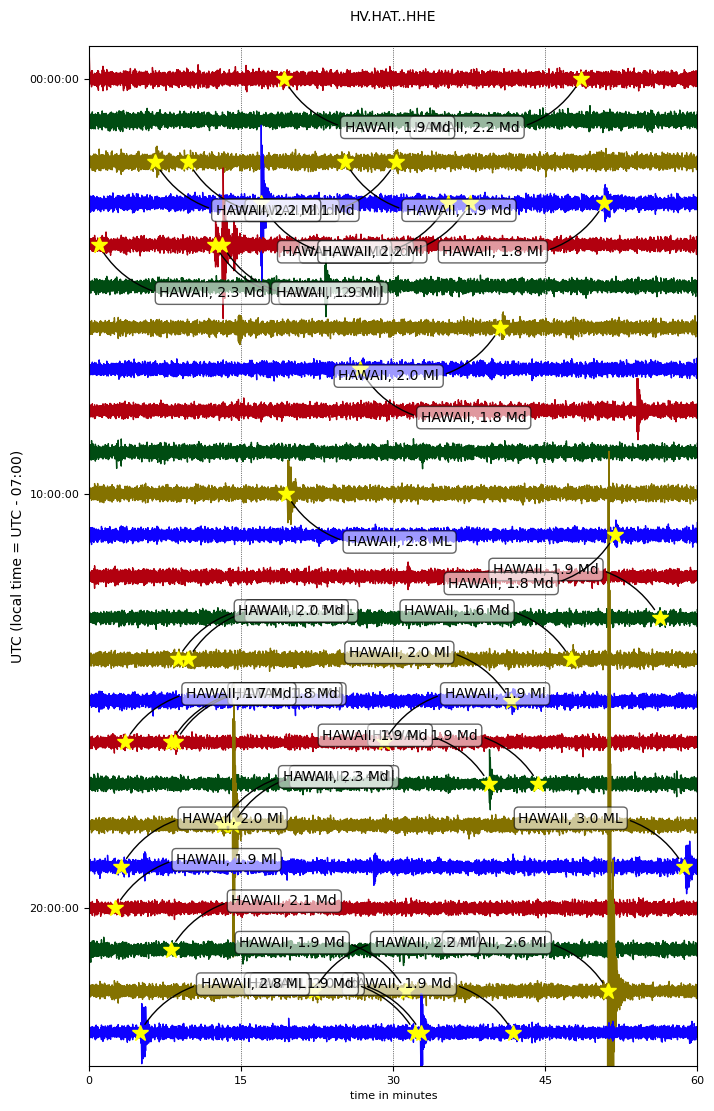

In [9]:
# Original waveform
tr[0].plot(type='dayplot', interval=60, size=(800, 1200), vertical_scaling_range=5e3, events=events)
plt.show()

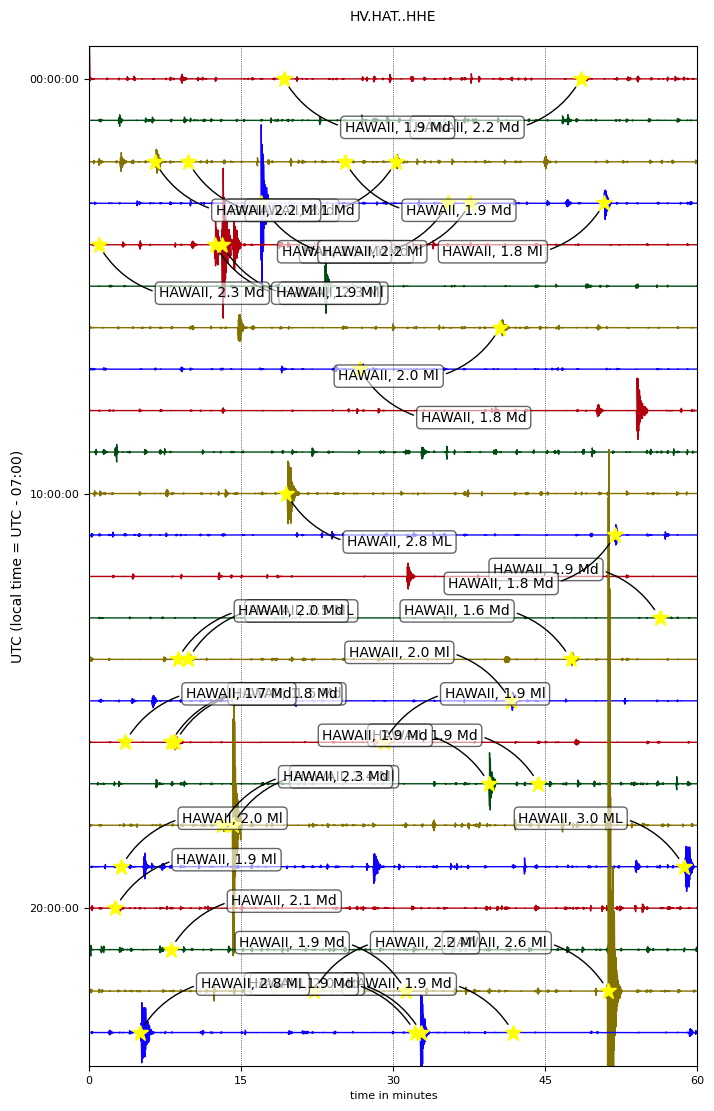

In [10]:
# Separated earthquake waveform
tr_eq[0].plot(type='dayplot', interval=60, size=(800, 1200), vertical_scaling_range=5e3, events=events)
plt.show()

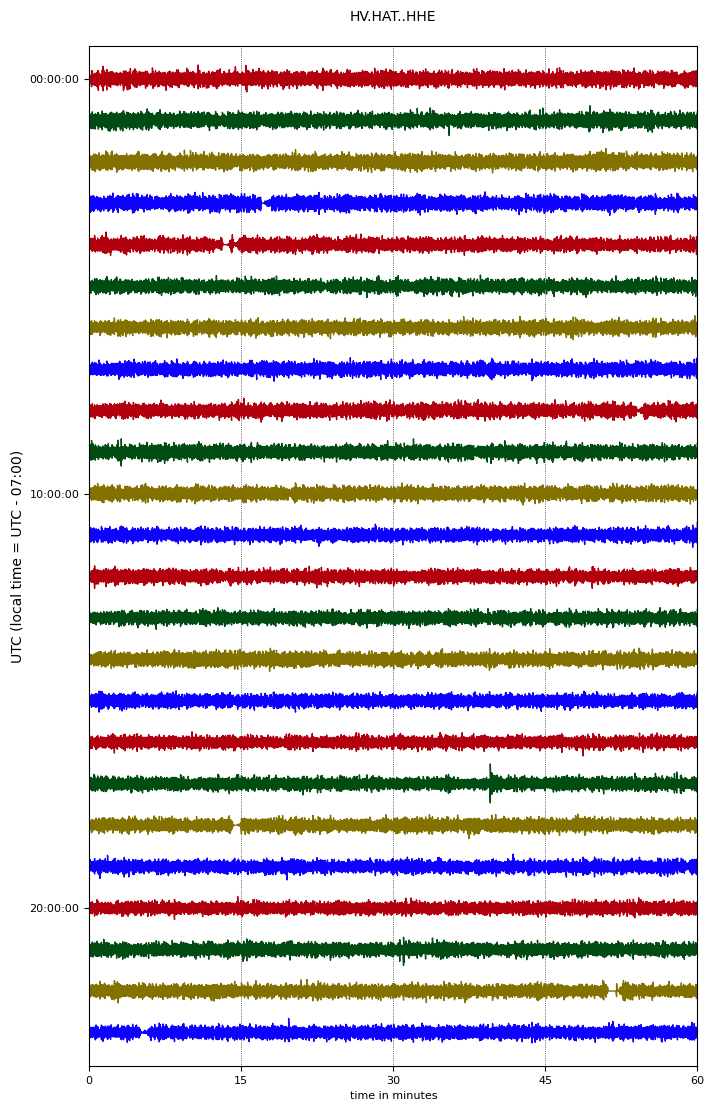

In [11]:
# Separated noise
tr_noise[0].plot(type='dayplot', interval=60, vertical_scaling_range=5e3, size=(800, 1200))
plt.show()

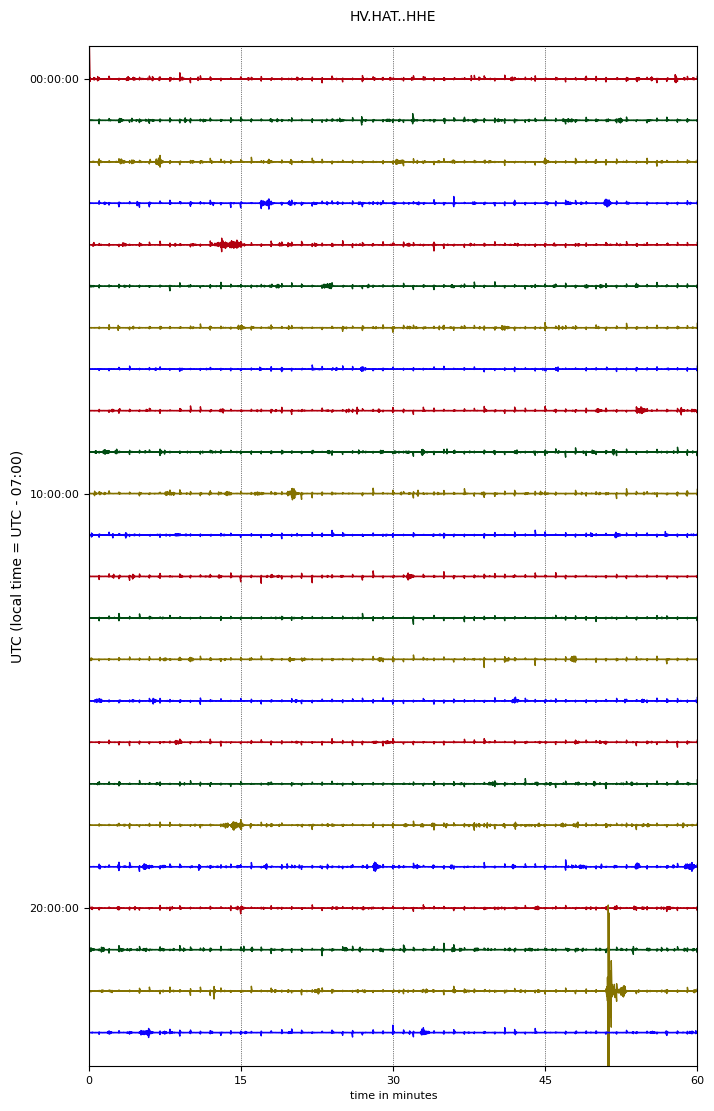

In [12]:
# Waveform residual 
tr_residual[0].plot(type='dayplot', interval=60, vertical_scaling_range=5e3, size=(800, 1200))
plt.show()